# CS 109A/AC 209A/STAT 121A Data Science: Homework 4 (Solutions)
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 5th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Last, First]

### Part (b): Course Number

[CS 109a or STATS 121a or AC 209a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Variable selection and regularization

The data set for this problem is provided in ``dataset_1.txt`` and contains 10 predictors and a response variable.

### Part (a): Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- If you were asked to select a minimal subset of predictors to build a good regression model, how many predictors will you pick, and which ones will you choose? 

**Solution:**

On visual inspection of the data, it is seen that the predictors 0, 1 and 2 are identical.

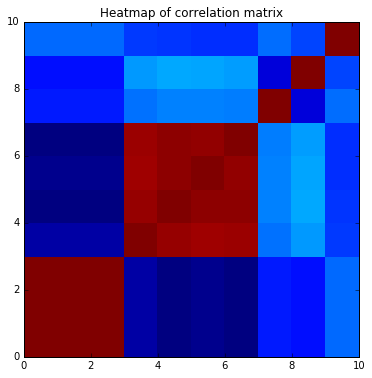

In [22]:
# Load data
data = np.loadtxt('datasets/dataset_1.txt', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:, :-1]
y = data[:, -1]

# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(x.T)

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolor(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

It appears that the predictors fall into **5 natural groups**. To build a regression model, one might pick a total of **5 predictors**, one from each group.

### Part (b): Selecting minimal subset of predictors

- Apply the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection
    
    - Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, use the Bayesian Information Criterion (BIC) to choose the subset size.

- Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

**Note**: You may use the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC.

**Solution:**

In [23]:
min_bic = 1e10 # set some initial large value for min BIC score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 
    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        # Use only a subset of predictors in the training data
        x_subset = x[:, predictor_subset]
        # Add a column of ones
        x_subset = np.hstack((x_subset, np.ones((x_subset.shape[0], 1))))
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate BIC of the best subset of size k
    model = OLS(y, x_subset)
    results = model.fit()
    bic = results.bic
    
    # Update minimum BIC and best predictor subset
    # If current predictor has a lower BIC score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(bic < min_bic): 
        min_bic = bic
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 5, 7, 8, 9]


In [24]:
### Step-wise Forward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors, and the remaining set of predictors
current_predictors = [] 
remaining_predictors = range(d)

# Set some initial large value for min BIC score for all possible subsets
global_min_bic = 1e10 

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, 0 predictors to d predictors
for size in range(d):    
    max_r_squared = -1e10 # set some initial small value for max R^2
    best_predictor = -1 # set some throwaway initial number for the best predictor to add
    bic_with_best_predictor = 1e10 # set some initial large value for BIC score   
        
    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        temp = current_predictors[:]
        # Add predictor 'i'
        temp.append(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        # Add a column of ones
        x_subset = np.hstack((x_subset, np.ones((x_subset.shape[0], 1))))
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            best_predictor = i
            bic_with_best_predictor = results.bic
    
    # Remove best predictor from remaining list, and add best predictor to current list
    remaining_predictors.remove(best_predictor)
    current_predictors.append(best_predictor)
    
    # Check if BIC for with the predictor we just added is lower than 
    # the global minimum across all subset of predictors
    if(bic_with_best_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_with_best_predictor
    
print 'Step-wise forward subset selection:'
print sorted(best_subset) # add 1 as indices start from 0

Step-wise forward subset selection:
[0, 5, 7, 8, 9]


In [25]:
###  Step-wise Backward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = range(d)

# First, fit and evaluate BIC using all 'd' number of predictors
model = OLS(y, x)
results = model.fit()
bic_all = results.bic

# Set the minimum BIC score, initially, to the BIC score using all 'd' predictors
global_min_bic = bic_all
# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 0, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_r_squared = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    bic_without_worst_predictor = 1e10 # set some initial large value for min BIC score  
        
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        # Add a column of ones
        x_subset = np.hstack((x_subset, np.ones((x_subset.shape[0], 1))))
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            worst_predictor = i
            bic_without_worst_predictor = results.bic
          
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    
    # Check if BIC for the predictor we just removed is lower than 
    # the global minimum across all subset of predictors
    if(bic_without_worst_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_without_worst_predictor
    
print 'Step-wise backward subset selection:'
print sorted(best_subset)

Step-wise backward subset selection:
[2, 5, 7, 8, 9]


The subset of predictors chosen by exhaustive search, backward selection and forward selection agrees with the correlation matrix we visualize in Part (a). That is, the best predictor subset contains five predictors, with **one predictor from each group of correlated predictors**.

### Part (c): Apply Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Is there a difference between the model parameters you obtain different and those obtained from Lasso regression? If so, explain why.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.

**Solution:**

In [26]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [ 0.02717417  0.          0.         -0.         -0.02532806 -0.         -0.
  0.04397321 -0.40612185 -0.22260474]
Predictors with non-zero coefficients: [0, 4, 7, 8, 9]


The subset of predictors chosen by Lasso agrees with the correlation matrix we visualize in Part (a). That is, the best predictor subset contains five predictors, with **one predictor from each group of correlated predictors**.

In [27]:
# Standardize data
x_std = Standardize(with_mean=False).fit_transform(x)

# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x_std, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Ridge:
Coefficients: [ 0.01202839  0.01202839  0.01202839  0.08215546 -0.05164384 -0.13888768
  0.06613925  0.05307179 -0.12990042 -0.10333556]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Unlike Lasso, the model parameters are **dense**. All predictors are assigned non-zero coefficients.

Also, the first three predictors are assigned the same coefficient in Ridge regression.
This is because the first three predictors take identical values. Hence, in building a regression model, one gets the same squared-error whether we use one or all of them. 

Now, the L2-norm penalty is minimized when the three predictors are assigned the same coefficients. More formally, let $C$ be a constant, and let $\beta_1, \beta_2, \beta_3$ be coefficients on the first three predictors that sum up to $C$, i.e. $\beta_1+\beta_2+\beta_3 = C$. Note that since the three predictors are identical, all such coefficients yield the same least square loss. However, among all these coefficients that sum up to $C$, the minimum L2-norm penalty $\beta_1^2 + \beta^2_2 + \beta^3_3$ is attained at $\beta^*_1 = \beta^*_2 = \beta^*_3 = \frac{C}{3}$.

## Problem 2: Cross-validation and Bootstrapping
In this problem, you will work with an expanded version of the automobile pricing data set you analyzed in Homework 3. The data set is contained ``dataset_2.txt``, with 26 attribues (i.e. predictors) for each automobile and corresponding prices. 

### Part(a): Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. You may do this using the `get_dummies()` function in `pandas`. If you do this task correctly, you should get a total of 69 predictors after the encoding.


**Solution:**

In [28]:
# Load data
data = pd.read_csv('datasets/dataset_2.txt')
        
# Separate predictors and response
x_df = data.iloc[:, :-1]
y_df = data.iloc[:, -1]

x_df.head(n=5)

,horsepower,highway-mpg,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,...,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg
0,95,24,0,120.232558,peugot,gas,std,four,wagon,rwd,...,3285,l,four,120,mpfi,3.46,2.19,8.4,5000,19
1,116,30,2,134.000000,toyota,gas,std,two,hardtop,rwd,...,2679,ohc,four,146,mpfi,3.62,3.50,9.3,4800,24
2,121,28,0,188.000000,bmw,gas,std,two,sedan,rwd,...,2710,ohc,six,164,mpfi,3.31,3.19,9.0,4250,21
3,184,16,0,120.232558,mercedes-benz,gas,std,four,sedan,rwd,...,3900,ohcv,eight,308,mpfi,3.80,3.35,8.0,4500,14
4,111,29,0,102.000000,subaru,gas,turbo,four,sedan,4wd,...,2510,ohcf,four,108,mpfi,3.62,2.64,7.7,4800,24


It certainly is the case that all string valued attributes are categorical (the type of some of these columns is 'object'). There are some numerical valued attributes that are also categorical (like symboling). 

In [29]:
# Create a new data frame to store one-hot encoding of attributes
x_df_expanded = pd.DataFrame({}) 

# Iterate over all attributes
for column in x_df.columns:
    # Check if attribute is categorical: has less than 8 unique values,
    # or is string values (column has type 'object')
    if len(x_df[column].unique()) < 8 or x_df[column].dtype == np.dtype('object'):
        # use one-hot encoding for this column
        encoding = pd.get_dummies(x_df[column])
        # append expanded attribute to data frame
        x_df_expanded = pd.concat([x_df_expanded, encoding], axis=1)
    else:
        x_df_expanded = pd.concat([x_df_expanded, x_df[[column]]], axis=1)

x_df_expanded.head(n=3)

,horsepower,highway-mpg,-2.0,0.0,1.0,1.09604519774,2.0,3.0,normalized-losses,audi,...,1bbl,2bbl,idi,mpfi,spdi,bore,stroke,compression-ratio,peak-rpm,city-mpg
0,95,24,0,1,0,0,0,0,120.232558,0,...,0,0,0,1,0,3.46,2.19,8.4,5000,19
1,116,30,0,0,0,0,1,0,134.000000,0,...,0,0,0,1,0,3.62,3.50,9.3,4800,24
2,121,28,0,1,0,0,0,0,188.000000,0,...,0,0,0,1,0,3.31,3.19,9.0,4250,21


### Part (b): Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?


- You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.


- Is there a need for regularization while fitting a linear model to this data set?

**Solution:**

In [30]:
# Convert data frame to numpy array
x = x_df_expanded.values
y = y_df.values

# Split data into train and test
n = x.shape[0]
n_train = int(np.round(n * 0.25))

# First 25% train, remaining test
x_train = x[:n_train, :]
y_train = y[:n_train]
x_test = x[n_train:, :]
y_test = y[n_train:]

In [31]:
# Fit plain regression on train set, evaluate on train and test sets
reg = Lin_Reg() #automatically fits intercept (adds column of one's) for you
reg.fit(x_train, y_train)

train_r_squared_plain = reg.score(x_train, y_train)
test_r_squared_plain = reg.score(x_test, y_test)

print 'Plain Regression: R^2 score on training set', train_r_squared_plain
print 'Plain Regression: R^2 score on test set', test_r_squared_plain

Plain Regression: R^2 score on training set 1.0
Plain Regression: R^2 score on test set -5.97542556701


**Observations:** 

The train R^2 score for plain regression is 1.0, while the test R^2 is negative. 

The test R^2 value is negative. While the R^2 score of a model evaluated on the same data set that it is fitted to needs to lie between 0 and 1, this need not be true when the model is evaluated on a held-out test set. 

In the case of dataset_2, the model over-fits the train set as the number of predictors (69) are comparable to the number of training instances (100), and a perfect fit is easily achieved. This is the reason for a train R^2 of 1, and a poor test R^2.

Clearly, there is a need for using regularization while fitting the regression model.

### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Solution:**

Ridge Regression: max R^2 score on training set 0.999999999666
Ridge Regression: max R^2 score on test set 0.933696632242


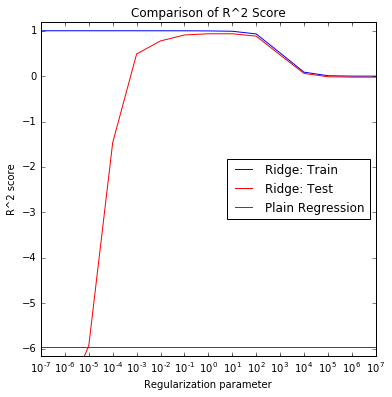

In [32]:
# Store test R-squared for different regression parameters
max_pow_of_10 = 7 # maximum power of 10
min_pow_of_10 = -7 # minimum power of 10
num_params = max_pow_of_10 - min_pow_of_10 + 1

train_r_squared = []
test_r_squared = []

#standardize x_train and y_train
std = Standardize(with_mean=False)
x_train_std = std.fit_transform(x_train)
x_test_std = x_test / std.scale_ 

for i in range(min_pow_of_10, max_pow_of_10 + 1):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(x_train_std, y_train)
        
    # Evaluate train & test performance
    train_r_squared.append(reg.score(x_train_std, y_train))
    test_r_squared.append(reg.score(x_test_std, y_test))
    
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            train_r_squared, 
            c='b', 
            label='Ridge: Train')
ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            test_r_squared, 
            c='r', 
            label='Ridge: Test')
ax.axhline(y=test_r_squared_plain, 
           c='g', 
           label='Plain Regression')

ax.set_xlabel('Regularization parameter')
ax.set_ylabel('R^2 score')
ax.set_ylim((test_r_squared_plain - 0.2, 1.2))
ax.set_title('Comparison of R^2 Score')
ax.legend(loc='best')

print 'Ridge Regression: max R^2 score on training set', max(train_r_squared)
print 'Ridge Regression: max R^2 score on test set', max(test_r_squared)

plt.show()

**Observations:**
- As the regularization parameter increases, the complexity of the fitted model reduces, and hence the train R^2 decreases. On the other hand, the test R^2 increases until a tipping point, and then decreases. This is because with lower model complexity, there is lower over-fitting. However, after the tipping point, the fitted model under-fits the data, leading to poor test R^2 values.

- As expected, Ridge regression with the best regularization parameter yields a slightly lower R^2 value than plain linear regression on the train set, but is significantly better on the test set.

**Note:** this exercise is to help you explore the relationship between the regularization parameter and R^2 values on train and test. In practice, you should **never** using test R^2 to tune your regularization parameters!

### Part (d): Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation on the training set. 

    - Plot the cross-validation (CV) R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score match the R^2 score on the test set? Does the model with lowest CV score (if calculating CV with MSE) or highest CV score (if calculating CV with R^2) correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV perform better than plain linear regression?


-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ by bootstrapping the training set with 100 samples. 

    - Plot the bootstrap R^2 score as a function of $\lambda$. 
    
    - How closely does the bootstrap score match the R^2 score on the test set? Does the model with lowest CV score (if calculating CV with MSE) or highest CV score (if calculating CV with R^2) correspond to the one the one with maximum R^2 on the test set?
    
    - Does the model chosen by bootstrapping perform better than plain linear regression?


**Solution:**

Ridge regression: Test R^2 score for CV choice 0.93363015961
Ridge regression: Max Test R^2 score 0.933696632242
Plain regression: Test R^2 score: -5.97542556701


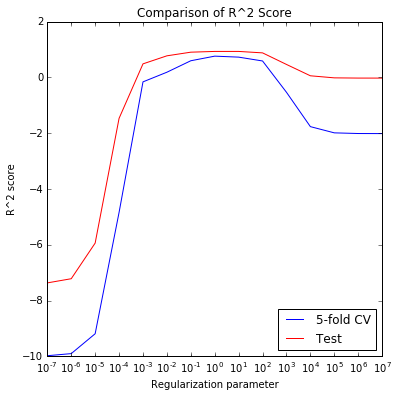

In [33]:
#--------  k_fold_r_squared
# A function for k-fold cross validation with Ridge regression
# Input: 
#      x_train (n x d array of predictors in training data)
#      y_train (n x 1 array of response variable vals in training data)
#      num_folds (no. of folds for CV)
#      param_val (regularization parameter value)
# Return: 
#      average R^2 value across folds

def k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train[:n * (fold - 1), :]
        x_second_half = x_train[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train[:n * (fold - 1)]
        y_second_half = y_train[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set, and evaluate CV test performance
        reg = Ridge_Reg(alpha = param_val)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

# Store test & CV R^2 values for different regression parameter values
# Range: 10^-7, ... 10^7
max_pow_of_10 = 7
min_pow_of_10 = -7
num_params = max_pow_of_10 - min_pow_of_10 + 1

test_r_squared = []
cv_r_squared = []

# Iterate over various parameter values
for power_of_10 in range(min_pow_of_10, max_pow_of_10+1):
    
    #standardize x_train and y_train
    std = Standardize(with_mean=False)
    x_train_std = std.fit_transform(x_train)
    x_test_std = x_test / std.scale_ 
    
    # Fit regression model on train set, and evaluate test R^2
    reg = Ridge_Reg(alpha=10**power_of_10)
    reg.fit(x_train_std, y_train)
    test_r_squared.append(reg.score(x_test_std, y_test))
    
    # Evaluate 5-fold CV R^2
    cv_r_squared.append(k_fold_r_squared(x_train_std, y_train, 5, 10**power_of_10))

# Plot CV and test R^2 values as a function of parameter value
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            cv_r_squared, 
            c='b', 
            label='5-fold CV')
ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1), 
            test_r_squared, 
            c='r', 
            label='Test')

ax.set_xlabel('Regularization parameter')
ax.set_ylabel('R^2 score')
ax.set_title('Comparison of R^2 Score')
ax.legend(loc='lower right')

# Best CV parameter value
best_cv_param = np.argmax(cv_r_squared)

# Print R^2 for best CV parameter, max R^2 across all parameters, and R^2 for plain regression
print 'Ridge regression: Test R^2 score for CV choice', test_r_squared[best_cv_param]
print 'Ridge regression: Max Test R^2 score', max(test_r_squared)
print 'Plain regression: Test R^2 score:', test_r_squared_plain

plt.show()

CV yields values that follow the **same 'trend'** as the test R^2 values. The test R^2 for the best CV choice is **slightly lower than the maximum test R^2**, but is however significantly **better than plain linear regression**. Since in practice we can **never** use test R^2 to select our regularization parameters, this exercises shows that CV score is a sufficient substitute for test R^2 in helping us select the best $\lambda$!

Ridge regression: Test R^2 for bootstrap choice 0.93363015961
Ridge regression: Max Test R^2 0.933696632242
Plain regression: Test R^2 score -5.97542556701


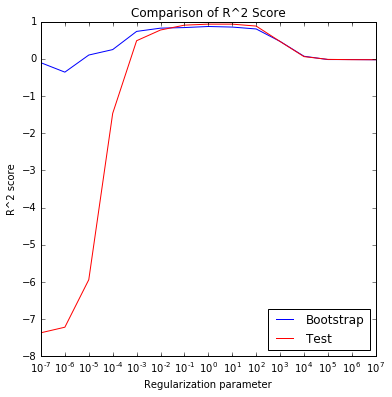

In [34]:
#--------  boot_strap_r_squared
# A function for k-fold cross validation with Ridge regression
# Input: 
#      x_train (n x d array of predictors in training data)
#      y_train (n x 1 array of response variable vals in training data)
#      num_samples (no. of bootstrap samples)
#      param_val (regularization parameter value)
# Return: 
#      average R^2 value across bootstrap samples

def boot_strap_r_squared(x_train, y_train, num_samples, param_val):
    n = x_train.shape[0]

    # Average of num_samples number of samples of size 'n'
    bs_r_squared = 0
    
    for fold in range(0, num_samples):
        # Randomly a sample points from the train set of size 'n'
        indices = np.random.choice(np.arange(0, n), size=n)
        
        x_train_sample = x_train[indices, :]
        y_train_sample = y_train[indices]

        # Evaluate R^2 on entire train set
        reg = Ridge_Reg(alpha = param_val)
        reg.fit(x_train_sample, y_train_sample)
        r_squared = reg.score(x_train, y_train)
        
        # Cumulative R^2 across bootstrap samples
        bs_r_squared += r_squared
    
    # Return average R^2 across bootstrap samples
    return bs_r_squared  * 1.0 / num_samples

# Store test & bootstrap R^2 for different regularization parameter values
# Range: 10^-7, ... 10^7
max_pow_of_10 = 7
min_pow_of_10 = -7
num_params = max_pow_of_10 - min_pow_of_10 + 1

test_r_squared = []
bs_r_squared = []

# Fit regression model on train set, and evaluate test R^2
for power_of_10 in range(min_pow_of_10,max_pow_of_10+1):
    
    #standardize x_train and y_train
    std = Standardize(with_mean=False)
    x_train_std = std.fit_transform(x_train)
    x_test_std = x_test / std.scale_ 
    
    # Fit ridge regression model on train set
    reg = Ridge_Reg(10**power_of_10)
    reg.fit(x_train_std, y_train)

    # Evaluate test R^2
    test_r_squared.append(reg.score(x_test_std, y_test))
    
    # Evaluate boostrap R^2
    bs_r_squared.append(boot_strap_r_squared(x_train_std, y_train, 100, 10**power_of_10))

# Plot bootstrap and test R^2 values as a function of parameter value
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10+1), 
            bs_r_squared, 
            c='b', 
            label='Bootstrap')
ax.semilogx(10.0**np.arange(min_pow_of_10, max_pow_of_10+1), 
            test_r_squared, 
            c='r', 
            label='Test')

ax.set_xlabel('Regularization parameter')
ax.set_ylabel('R^2 score')
ax.set_title('Comparison of R^2 Score')
ax.legend(loc='lower right')

# Best boostrap parameter value
best_bs_param = np.argmax(bs_r_squared)

# Print R^2 for best boostrap parameter, max R^2 across all parameters, and R^2 for plain regression
print 'Ridge regression: Test R^2 for bootstrap choice', test_r_squared[best_bs_param]
print 'Ridge regression: Max Test R^2', max(test_r_squared)
print 'Plain regression: Test R^2 score', test_r_squared_plain

plt.show()

Bootstrapping yields values that follow the **same 'trend'** as the test R^2 values. The test R^2 for the best bootstrap choice is **slightly lower than the maximum test R^2**, but is however significantly **better than plain linear regression**. Since in practice we can **never** use test R^2 to select our regularization parameters, this exercises shows that bootstrapping is a sufficient substitute for test R^2 in helping us select the best $\lambda$!

## Problem 3: Ridge regression *via* ordinary least-squares regression

We present an approach to implement Ridge regression using oridinary least-squares regression. Given a matrix of responses $\mathbf{X} \in \mathbb{R}^{n\times p}$ and response vector $\mathbf{y} \in \mathbb{R}^{n}$, one can implement Ridge regression with regularization parameter $\lambda$ as follows:

- Augment the matrix of predictors $\mathbf{X}$ with $p$ new rows containing the scaled identity matrix $\sqrt{\lambda}\mathbf{I} \in \mathbb{R}^{p \times p}$, i.e.
$$\overline{\mathbf{X}} \,=\, 
\begin{bmatrix}
X_{11} & \ldots & X_{1p}\\
\vdots & \ddots & \vdots\\
X_{n1} & \ldots & X_{np}\\
\sqrt{\lambda} & \ldots & 0\\
\vdots & \ddots & \vdots\\
0 & \ldots & \sqrt{\lambda}
\end{bmatrix}
\,\in\,
\mathbb{R}^{(n+p)\times p}
.
$$


- Augment the response vector $\mathbf{y}$ with a column of $p$ zeros, i.e.
$$
\overline{\mathbf{y}} \,=\, 
\begin{bmatrix}
y_{1}\\
\vdots\\
y_{n}\\
0\\
\vdots\\
0
\end{bmatrix}
\,\in\,
\mathbb{R}^{n+p}.
$$


- Apply ordinary least-squares regression on the augmented data set $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$.

### Part (a): Show the proposed approach implements Ridge regression
Show that the approach proposed above implements Ridge regression with parameter $\lambda$.

**Solution:**

The ordinary least-squares loss function with the augmented data is given by
$$
\begin{eqnarray*}
\overline{L}(\beta) &=& (\overline{\mathbf{X}}\beta \,-\, \overline{\mathbf{y}})^\top(\overline{\mathbf{X}}\beta \,-\, \overline{\mathbf{y}})\\
&=& (\beta^\top\overline{\mathbf{X}}^\top \,-\, \overline{\mathbf{y}}^\top)(\overline{\mathbf{X}}\beta \,-\, \overline{\mathbf{y}})\\
&=& (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{X}}\beta \,-\, \overline{\mathbf{y}}^\top\overline{\mathbf{X}}\beta \,-\, (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}} \,+\, \overline{\mathbf{y}}^\top\overline{\mathbf{y}}\\
&=& (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{X}}\beta \,-\, ((\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}})^\top \,-\, (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}} \,+\, \overline{\mathbf{y}}^\top\overline{\mathbf{y}}
\end{eqnarray*},
$$
where $\beta \in \mathbb{R}^p$ is the coefficient vector (1-d array).

Now, note that since $\overline{\mathbf{y}}$ and $\overline{\mathbf{X}}\beta$ are vectors (1-dimensional arrays), $(\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}}$ is just a real number. Thus, we have $$((\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}})^\top = (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}}.$$ 

So we get:
$$
\begin{eqnarray*}
\overline{L}(\beta) &=& (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{X}}\beta \,-\, ((\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}})^\top \,-\, (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}} \,+\, \overline{\mathbf{y}}^\top\overline{\mathbf{y}}\\
&=& (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{X}}\beta \,-\,2 (\overline{\mathbf{X}}\beta)^\top\overline{\mathbf{y}} \,+\,  \overline{\mathbf{y}}^\top\overline{\mathbf{y}}\\
&=& \sum_{i=1}^{n+p} \overline{\mathbf{X}}_i\beta^2 - 2 \sum_{i=1}^{n+p} (\overline{\mathbf{X}}_i\beta) \overline{\mathbf{y}}_i \,+\, \sum_{i=1}^{n+p} \overline{\mathbf{y}}_i^2\\
&=& \sum_{i=1}^{n+p} \overline{\mathbf{X}}_i\beta^2 - 2(\overline{\mathbf{X}}_i\beta)\overline{\mathbf{y}}_i + \overline{\mathbf{y}}_i^2\\
&=& \sum_{i=1}^{n+p} (\overline{\mathbf{X}}_i\beta - \overline{\mathbf{y}}_i)^2\\
&=& \sum_{i=1}^{n}(X_i\beta \,-\, y_i)^2 + \sum_{i=n + 1}^p(\overline{\mathbf{X}}_i\beta - \overline{\mathbf{y}}_i)^2\\
&=& \sum_{i=1}^n (X_i\beta \,-\, y_i)^2  \,+\, \sum_{j=1}^p (\sqrt{\lambda}\beta_j \,-\, 0)^2\\
&=& \sum_{i=1}^n (X_i\beta \,-\, y_i)^2 \,+\, \lambda \sum_{j=1}^p \beta_j^2\\
\end{eqnarray*},
$$
From the above, we see that the OLS loss function with $\overline{\mathbf{X}}$ and $\overline{\mathbf{y}}$ is exactly the loss function of Ridge regression.

Thus the ordinary least-squares solution to the augmented data set is the same as the Ridge regression solution to the original data set.

### Part (b): Debug our implementation of ridge regression
You're a grader for CS109A, the following is an implemention of Ridge regression (via the above approach) submitted by a student. The dataset is ``dataset_3.txt``. The regression model is fitted to a training set, and the R^2 scores of the fitted model on the training and test sets are plotted as a function of the regularization parameter. Grade this solution according to the following rubric (each category is equally weighted): 

- correctness

- interpretation (if applicable)

- code/algorithm design

- presentation

In addition to providing an holistic grade (between 0 to 5), provide a corrected version of this code that is submission quality.

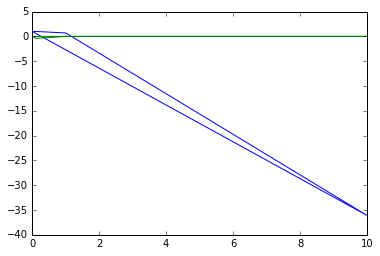

In [91]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    y_train_=np.zeros((n+np.shape(x_train)[1],1))
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1))
    return model

# Score
def score(m,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100]
y_train = data[0:n,100]
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

**Solution:**

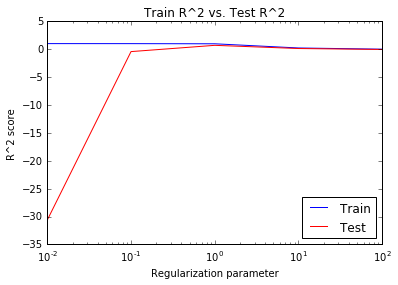

In [92]:
# CHANGES TO IMPROVE READABILITY:
#    Split operations into multiple statements
#    Rename variables with meaningful names
#    Add comments

#--------  ridge_regression_fit
# A function to fit a Ridge regression, using a call to linear regression
# Input: 
#      x_train (n x d array of predictors in training data)
#      y_train (n x 1 array of response variable vals in training data)
#      reg_param (regularization parameter value)
# Return: 
#      sklern regression model object

def ridge_regression_fit(x_train, y_train, reg_param):
    # No. of predictors
    d = x_train.shape[1]
    
    # CORRECT BUG 1:
    #   Replace axis = 1 with axis = 0 (append rows not columns)
    
    # Append an identity matrix of size d to the predictors matrix
    identity = reg_param * np.identity(d)
    x_train_expanded = np.concatenate((x_train, identity), axis=0)
    
    # CHANGE:
    #   Replace loop with a concatenation operation (more efficient)
    
    # Append a column of zeros of size d to the response vector
    zeros_col = np.zeros((d, 1))
    y_train = y_train.reshape((d, 1))
    y_train_expanded = np.concatenate((y_train, zeros_col), axis=0)
    
    # CORRECT BUG 2:
    #   Passto fit() function the expanded response vector instead of original vector
    
    # Fit linear regression on expanded data set
    model = Lin_Reg()
    model.fit(x_train_expanded, y_train_expanded)
    
    return model

#--------  ridge_regression_score
# A function to score a Ridge regression model
# Input: 
#      model (sklearn regression model object)
#      x_test (n x d array of predictors in test data)
#      y_test (n x 1 array of response variable vals in test data)
# Return: 
#      r_squared (float)

def ridge_regression_score(model, x_test, y_test):
    # SIMPLIFY FUNCTION:
    #    No need to modify the test set
    #    Directly call score() function in model object
    #    Regularization parameter not required as input
    
    r_squared = model.score(x_test, y_test)
    return r_squared

# Load data, split predictors and response
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
x = data[:, 0:-1]
y = data[:, -1]

# CHANGE:
#   Remove hard-coded dimension/indices

# No. of training points
n = x.shape[0]
n_train = int(np.round(n * 0.5))

# First 25% train, remaining test
x_train = x[:n_train, :]
y_train = y[:n_train]
x_test = x[n_train:, :]
y_test = y[n_train:]

# CHANGE:
#   Remove hard-coded parameter ranges, instead store the limits in variables

# Range of parameters
min_pow_of_10 = -2 # minimum power of 10
max_pow_of_10 = 2 # maximum power of 10
num_params = max_pow_of_10 - min_pow_of_10 + 1 # Total no. of parameters

# Store train and test R-squared for different regression parameters
train_r_squared = np.zeros(num_params)
test_r_squared = np.zeros(num_params)

# CORRECT BUG 3:
#   The range() needs to take values from -2 to 3, since range(-2, 2) 
#   doesn't include the last index!
#   Here we we replace loop with the arange() function (more efficient)
#   The upper limit is max_pow_of_10 + 1

# Iterate over parameter values
parameter_values = 10.0**np.arange(min_pow_of_10, max_pow_of_10 + 1)

# CORRECT BUG 4:
#   Correct bug in loop indexing ('i' and 'j' mixed)

for i in range(num_params):    
    # Fit ridge regression on train set
    model = ridge_regression_fit(x_train, y_train, parameter_values[i])
        
    # Evaluate test performance, and store in array
    train_r_squared[i] = ridge_regression_score(model, x_train, y_train)
    test_r_squared[i] = ridge_regression_score(model, x_test, y_test)

# CHANGE:
#   Change axis to log-scale
#   Add x-label, y-label, legend, title

# Plot test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogx(parameter_values, train_r_squared, c='b', label='Train')
ax.semilogx(parameter_values, test_r_squared, c='r', label='Test')

ax.set_xlabel('Regularization parameter')
ax.set_ylabel('R^2 score')
ax.set_title('Train R^2 vs. Test R^2')

ax.legend(loc = 'best')

plt.show()

## Challenge Problem: Predicting Outcome of a Fund-raising Campaign
You are provided a data set containing details of mail sent to 95,412 potential donors for a fund-raising campaign of a not-for-profit organization. This data set also contains the amount donated by each donor. The task is to build a model that can estimate the amount that a donor would donate using his/her attributes. The data is contained in the file `dataset_3.txt`. Each row contains 376 attributes for a donor, followed by the donation amount.

### Part (a): Fit regression model
Build a suitable model to predict the donation amount. How good is your model? 


### Part (b): Evaluate the total profit of the fitted model
Suppose you are told that the cost of mailing the donor is \$7. Use your model to maximize net gain from contributions. Implement, explain and rigorously justify your strategy. How does your strategy compare with blanket mailing everyone.

### Part (c): Further Discussion
In hindsight, thoroughly discuss the appropriateness of using a regression model for this dataset (you must at least address the suitability with respect to profit maximization and model assumptions). Rigorously justify your reasoning. 

**Solutions to all parts**:

Since it costs \$7 to mail an envelope, we should only send one if the doner is predicted to donate more than \$7! Our baic strategy, rather than blanket mailing everyone, is to find doners who are predicted to donate more that \$7 and mail evelopes to them.

In [3]:
# STEP 1: Load and inspect the data

data = pd.read_csv('datasets/dataset_4.txt', low_memory=False)  # low memory is set false for better type inference
data.head()

,OSOURCE,TCODE,STATE,MAILCODE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,...,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2,TARGET_D
0,BBK,2,MN,_,0,_,_,_,_,XXXX,...,1,L,3,D,X,X,X,3,A,4
1,SYN,0,TX,_,0,_,_,_,_,XXXX,...,1,L,3,D,X,X,X,14,A,7
2,DRK,0,IA,_,0,_,_,_,_,XXXX,...,1,L,3,D,X,X,X,11,C,5
3,BHG,0,CA,_,0,_,_,_,_,XXXX,...,0,L,2,F,X,X,X,2,A,13
4,L01,1,GA,_,0,_,_,_,_,XXXX,...,1,L,3,E,X,X,X,22,A,10


In [8]:
# STEP 2: Clean the data

# Categoricals will be int or str (object), the rest float

# List of columns to be converted to floating point
to_float = ['HIT', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'NUMPRM12', 
           'CARDPM12', 'CARDPROM', 'NUMPROM', 'NGIFTALL', 'CARDGIFT']

# Converted columns to floating point
for feature_name in to_float:
    data[feature_name] = data[feature_name].astype(float)

# Columns between POP901 to AC2 should all be float
index1 = data.columns.get_loc("POP901")
index2 = data.columns.get_loc("AC2")

for i in range(index1, index2 + 1):
    data.iloc[:, i] = data.iloc[:, i].astype(float)

In [ ]:
# STEP 3: Encode categorical variables using sklearn's one-hot encoder
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return Preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (data.dtypes.values != np.dtype('float64'))

# Encode all labels
data = data.apply(encode_categorical)

# Get numpy array from data
x = data.iloc[:, :-1].as_matrix()
y = data.iloc[:, -1].as_matrix()

# Apply one hot endcoing
encoder = Preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)

In [10]:
# STEP 4: Train regression model

# Test/train split
n_samples = x.shape[0]
train = np.random.uniform(size=n_samples) > 1. / 3.  # Select two thirds for train

x_train = x[train]
y_train = y[train]

x_test = x[~train]
y_test = y[~train]

cost_per_donor = 7

done


### Plain Linear Regression

In [11]:
# TEST profits with regular regression (no regularization)

# Fit regression model on train set
reg = Lin_Reg()
reg.fit(x_train, y_train)

# Evaluate R^2 score on train and test sets
train_r_squared = reg.score(x_train, y_train)
test_r_squared = reg.score(x_test, y_test)

print 'Plain Linear Regression'
print 'Train R^2 score:', train_r_squared 
print 'Test R^2 score:', test_r_squared

# Evaluate profit on test set
y_pred = reg.predict(x_test)

doners = (y_pred - cost_per_donor) > 0
profit = (y_test[doners] - cost_per_donor).sum()

print 'Total donation:', profit

Plain Linear Regression
Train R^2 score: 0.591180205269
Test R^2 score: -3.67498089869e+13
Total donation: 4208.75


### Ridge regression

In [62]:
# Rewrite with MSE instead of R-squared
# (as the labels have a lot of zeros, hence r_squared can blow up)
def k_fold_perf_mse(x, y, n_folds, param_val):
    n_train = np.shape(x_train)[0]
    n = int(np.round(n_train * 1. / n_folds)) # points per fold
    
    # Iterate over folds
    cv_mse = 0
    for fold in range(1, n_folds + 1):
        x_train_cv = np.concatenate((x_train[:n * (fold - 1), :], x_train[n * fold + 1:, :]), axis=0)
        y_train_cv = np.concatenate((y_train[:n * (fold - 1)], y_train[n * fold + 1:]), axis=0)

        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set
        reg = Ridge_Reg(alpha = param_val)
        reg.fit(x_train_cv, y_train_cv)
        
        # Evaluate mean squared error of model on CV test set
        y_pred_cv = reg.predict(x_test_cv)
        mse = np.mean(np.square(y_test_cv - y_pred_cv))

        cv_mse += mse

    return cv_mse * 1.0 / n_folds


# CV to tune parameter in Ridge regression
min_mse = 1e10 # some high value
min_param = -1

for power_of_10 in range(-7, 7):
    cv_mse = k_fold_perf_mse(x, y, 5, 10.0**power_of_10)
    
    if(cv_mse < min_mse):
        min_mse = cv_mse
        min_param = 10**power_of_10
    
# Fit regression model with opt parameter on train set
reg = Ridge_Reg(alpha = min_param)
reg.fit(x_train, y_train)

# Evaluate R-squared on train and test sets
train_r_squared = reg.score(x_train, y_train)
test_r_squared = reg.score(x_test, y_test)

print 'Ridge regression'

print "Train R-squared:", train_r_squared 
print "Test R-squared:", test_r_squared

# Evaluate profit on test set
y_pred = reg.predict(x_test)

doners = (y_pred - cost_per_donor) > 0
profit = (y_test[doners] - cost_per_donor).sum()

print "Total donations:", profit

Ridge regression
Train R-squared: 0.112346229735
Test R-squared: 0.117767484207
Total donations: 6047.0


### Default Strategy

In [61]:
print 'Default strategy'
print 'Total donation:', (y_test - cost_per_donor).sum()

Default strategy
Total donation: 4825.42


Notice that both linear regression and ridge regression have very low R^2 scores on the test set. In terms of R^2, both models are extremely poor fits. On ther other hand notice that using the ridge regression's donation predictions to only send mailers to doners who are predicted to donate more than \$7 yields a much higher net gain than blanket mailing very one! Should we be surprised? One conclusion to draw here is that R^2 shouldn't be the end-all be-all final word on model fit. **How we evaluate the "goodness" of a model should depend on ultimately what we want to use the model to do.** In this regard, a "bad" model by some measures can be a "good" model by others.

Now, why is it that both linear and ridge regression do poorly in terms of R^2 on this data? Is it that the data is simply not linear? What else might make doing regression (and linear regression in particular) inappropriate for this data? **Hint:** think about, again, what the model should ultimately do: not to predict how much a doner will donate but whether the doner will donate over \$7. Think also about the number of categorical variables present in the data set.